# Lab 3 — recommender systems

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
plt.style.use("ggplot")

What does the data look like?

In [2]:
!hdfs dfs -cat /ix/ml-20m/ratings.txt | tail -n 2

{"movieId": 70286, "userId": 138493, "timestamp": 1258126944, "rating": 5.0}
{"movieId": 71619, "userId": 138493, "timestamp": 1255811136, "rating": 2.5}


In [40]:
data = sc.textFile("/ix/ml-20m/ratings.txt").map(json.loads)

## Exercise 3.4 Basic statistics :

Users :

In [4]:
users_ratings = data.map(lambda x: (x['userId'], x['rating']))
users_counts = sorted(users_ratings.countByKey().items())

Movies

In [5]:
movies_ratings = data.map(lambda x: (x['movieId'], x['rating']))
movies_counts = sorted(movies_ratings.countByKey().items())

Now let's plot :

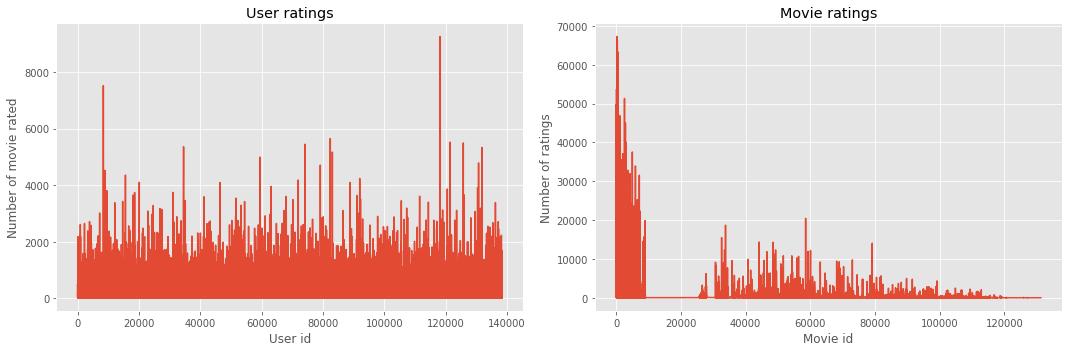

In [6]:
users_counts_graph = list(zip(*users_counts))
movies_counts_graph = list(zip(*movies_counts))

fig, axes = plt.subplots(ncols=2,figsize=(15, 5))

ax = axes[0]
ax.plot(*users_counts_graph)
ax.set_xlabel('User id')
ax.set_ylabel('Number of movie rated')
ax.set_title('User ratings')
ax = axes[1]
ax.plot(*movies_counts_graph)
ax.set_xlabel('Movie id')
ax.set_ylabel('Number of ratings')
ax.set_title('Movie ratings')
plt.tight_layout()
plt.show();

Some users have a lot of ratings as well as movies and users having little number of ratings. The distributions of the ratings isn't balanced uniformly (note that is is "more balanced" on the user's side).

## Exercise 3.5 Partitioning the dataset :

In [7]:
personnal_ratings = list() ## add the personnal ranking somehow
with open("my-ratings.txt") as f :
    for line in f:
        personnal_ratings.append(json.loads(line.strip()))

newData = data.union(sc.parallelize(personnal_ratings))

training = newData.filter(lambda x: (x['timestamp'] % 10) > 1).map(lambda x: (x['userId'], x['movieId'], x['rating']))
test = newData.filter(lambda x: (x['timestamp'] % 10) <= 1).map(lambda x: (x['userId'], x['movieId'], x['rating']))

We use the hint given in the handout (using the last digits of the timestamp) in order to separate the data into 80% for the training and 20% for the testing.

### Baseline recommender system

#### Baseline model

In [8]:
mu = training.map(lambda x: x[2]).mean()

In [9]:
mu

3.5255073364131326

Knowing mu we can compute the user bias

In [10]:
## find how to get all_user_bias and all_item_bias
all_user_mean = training.map(lambda x: (x[0], x[2])).aggregateByKey((0,0), lambda a,b: (a[0] + b,a[1] + 1), lambda a,b: (a[0] + b[0], a[1] + b[1])).mapValues(lambda v: v[0]/v[1])
all_user_bias = all_user_mean.map(lambda x: (x[0], x[1]-mu))

In [11]:
mean_user_bias = all_user_bias.values().mean()
mean_user_bias

0.10160805230563545

We now can compute the item bias using the mu and user bias computed previously

In [12]:
collected_all_user_bias = all_user_bias.collectAsMap()

In [13]:
all_item_bias = training.map(lambda x: (x[1], x[2] - collected_all_user_bias[x[0]] - mu)).aggregateByKey((0,0), lambda a,b: (a[0] + b,a[1] + 1), lambda a,b: (a[0] + b[0], a[1] + b[1])).mapValues(lambda v: v[0]/v[1])

In [14]:
mean_item_bias = all_item_bias.values().mean()
mean_item_bias

-0.20496287461285176

In [84]:
collected_all_item_bias = all_item_bias.collectAsMap()

In [82]:
def user_bias(userId):
    if userId in all_user_bias.keys().collect():
        return collected_all_user_bias[userId]
    
    return mean_user_bias

def item_bias(movieId):
    if movieId in all_item_bias.keys().collect():
        return collected_all_item_bias[movieId]
    
    return mean_item_bias

Note : The baseline model's number of parameter is : number of user + number of movies

In [41]:
numberOfUsers = data.map(lambda x: x['userId']).distinct().count()
numberOfMovies = data.map(lambda x: x['movieId']).distinct().count()
print("Number of parameters is : %d"%(numberOfUsers+numberOfMovies))

Number of parameters is : 165237


Now to compute the prediction for a single user movie pair, or all pairs we use the 2 functions below :

In [16]:
def predict(user, movie):
    return ((user, movie), mu + user_bias(user) + item_bias(movie))

In [17]:
def predict_all(users_movies):
    return users_movies.map(lambda x: predict(x[0], x[1]))

For the baseline model :

In [86]:
predictions = predict_all(user_movie)

#### Evaluation

In [47]:
def errorFct(rdd):
    ranks_predictions = test.map(lambda x: ((x[0], x[1]), x[2])).join(rdd)
    
    errors = ranks_predictions.map(lambda t: (t[0][0], (t[1][0] - t[1][1]) ** 2))
    
    error_mean = errors.aggregateByKey((0,0), lambda a,b: (a[0] + b,a[1] + 1), lambda a,b: (a[0] + b[0], a[1] + b[1])).mapValues(lambda v: v[0]/v[1])
    
    err = error_mean.map(lambda u: np.sqrt(u[1])).mean()
    
    return err

In [88]:
baseLineError = errorFct(prediction)

In [89]:
print('Error for the baseline model: ', baseLineError)

Error for the baseline model:  0.859733140644


### Matrix-factorization model

In [19]:
from pyspark.mllib.recommendation import ALS

Lower rank implies simpler model, thus a faster training. Higher rank increases the amount of parameters used in the learning process, thus the probability of overfitting increases with the rank.

In [20]:
## We choose the rank to be between 5 and 25 and decided to take 11
rank = 11
predictions_param = test.map(lambda x: (x[0],x[1]))

#### Regularization

In [22]:
param = 10e-4
model1 = ALS.train(training, rank, lambda_=param)
prediction = model1.predictAll(predictions_param).map(lambda x: ((x[0], x[1]), x[2]))


error1 = errorFct(prediction)
print('Error with lambda=10^-4: ', error1)

Error with lambda=10^-4:  0.859733140644


In [23]:
param2 = 10.0
model2 = ALS.train(training, rank, lambda_=param2)
prediction2 = model2.predictAll(predictions_param).map(lambda x: ((x[0], x[1]), x[2]))


error2 = errorFct(prediction2)
print('Error with lambda=10.0: ', error2)

Error with lambda=10.0:  3.74687983336


In [25]:
## Find optimal lambda below
## optimal_lambda = VALUE
for lambda_ in [0.001,0.01,0.1,1.0]:
    error_model = ALS.train(training, rank, lambda_=lambda_)
    error_prediction = error_model.predictAll(predictions_param).map(lambda x: ((x[0], x[1]), x[2]))
    error = errorFct(error_prediction)
    print("Error with %f is %f"%(lambda_,error))

Error with 0.001000 is 0.858226
Error with 0.010000 is 0.840507
Error with 0.100000 is 0.812776
Error with 1.000000 is 1.340811


Thus, wee see that the optimal lambda is 0.1

In [26]:
optimal_lambda = 0.1

In [90]:
optimalError = 0.812776

In [91]:
print("Improvement over the error of the baseline recommender system %f"%(optimalError/baseLineError))

Improvement over the error of the baseline recommender system 0.945382


#### Recommendation

In [27]:
from operator import itemgetter

In [28]:
model = ALS.train(newData.map(lambda x: (x['userId'], x['movieId'], x['rating'])), rank=10, lambda_=optimal_lambda)

movies = sc.textFile("/ix/ml-20m/movies.txt").map(json.loads)
ids_to_title = movies.map(itemgetter("movieId", "title")).collectAsMap()

In [29]:
## Do the recommendation for both users
def user_recommendation(userId, top_n):
    recomendations = model.recommendProducts(userId, top_n)
    movie_ids = [rating[1] for rating in recomendations]
    movies = [ids_to_title[movie_id] for movie_id in movie_ids]
    return movies

In [30]:
first_user = 123
user_recommendation(first_user, 10)

['Marihuana (1936)',
 'No Distance Left to Run (2010)',
 'Moth, The (Cma) (1980)',
 'Bill Hicks: Sane Man (1989)',
 'My Brother Tom (2001)',
 'Peppermint Soda (Diabolo menthe) (1977)',
 'Island at War (2004)',
 'Diplomatic Immunity (2009– )',
 'Supermarket Woman (Sûpâ no onna) (1996)',
 "It's Love I'm After (1937)"]

In [31]:
second_user = 138494
user_recommendation(second_user, 10)

['No Distance Left to Run (2010)',
 'Marihuana (1936)',
 "Ain't in It for My Health: A Film About Levon Helm (2013)",
 'Mutant Aliens (2001)',
 'Silver Stallion (Silver Brumpy, The) (1993)',
 "Uwasa No Onna (The Woman in the Rumor) (Her Mother's Profession) (1954)",
 'Crazy Stone (Fengkuang de shitou) (2006)',
 'Green Man, The (1956)',
 'Eros Plus Massacre (Erosu purasu Gyakusatsu) (1969)',
 'Drained (O cheiro do Ralo) (2006)']

#### Visualisation

In [32]:
import pickle

In [34]:
visualisation_model = ALS.train(training, rank=2, lambda_=optimal_lambda)

In [35]:
with open("selected-movies.pickle", "rb") as f:
    selected_movies = pickle.load(f, encoding='utf-8')

In [36]:
model_features = visualisation_model.productFeatures()

selected_movie_id = {movie[0] for movie in selected_movies}

selected_movie_features = model_features.filter(lambda x: x[0] in selected_movie_id).collect()

In [37]:
names = [x[1] for x in selected_movies]
ratings = [x[2] for x in selected_movies]
features = np.asarray([x[1] for x in selected_movie_features])

In [38]:
import sklearn.cluster
import random
from bokeh.io import show, output_notebook
from bokeh.layouts import gridplot
from bokeh.plotting import figure, ColumnDataSource
from bokeh.models import HoverTool, ResetTool, PanTool, WheelZoomTool, SaveTool
from bokeh.palettes import Category10
from matplotlib.colors import rgb2hex
output_notebook()

data=dict(x=[],
          y=[],
          name=[],
          score=[],
          color=[])

for movie in selected_movies:
    coords = model_features.collectAsMap()[movie[0]]
    data['x'].append(coords[0])
    data['y'].append(coords[1])
    data['name'].append(movie[1])
    data['score'].append(movie[2])
    data['color'].append(rgb2hex(plt.get_cmap('RdYlGn')(movie[2])[:3]))
source = ColumnDataSource(data)
hover = HoverTool(
        tooltips=[
            ("name", "@name"),
            ("score","@score"),
        ]
    )

p = figure(plot_width=600, plot_height=600, tools=[hover],
           title="Movies")

p.circle('x', 'y', size=20, source=source, color='color')

show(p)

Loading BokehJS ...

### Obersvations

High rated films have a tendency in the upper right corner.
Low rated films in the low left corner.

We can find some "classifications" :

In the really low left part : bad comedies

In the middle (a bit up right) : quite good action/adventure/sci fi

In the up right part: good dramas

"Naming the axis" could be done by saying that on the horizontal axis, from left to right is the comical aspect of the film and
on the vertical axis, we could put the genre/type of the film (comedies, actions, dramas,...).